<h1>Medical Insurance Premium Prediction</h1>
<h3>Viktoriia Ilina</h3>
<h3>October 2021</h3>

<h2>Introduction</h2>
According to PoliyX's Insurance Price Index data, the average health insurance premium in India is ₹25,197 in the second quarter of 2021[1]. However, costs may vary among the wide selection of health plans. The main goal of this project is trying to make an accurate prediction model of the insurance costs based on personal health data. Additionally, we are going to determine what the most important variable influencing insurance premium is. The dataset was downloaded from Kaggle and scopes voluntarily given health history of 986 customers of a medical insurance company[2].

<h2>The exploratory data analysis</h2>
To begin with, we should install and import all necessary libraries and load the data. The .csv file from Kaggle has been uploaded to the author’s GitHub account. 

In [48]:
!pip install pandas
import pandas as pd
!pip install plotly
!pip install cufflinks
import cufflinks as cf
from IPython.display import display,HTML
cf.set_config_file(sharing = 'public', theme = 'white', offline = True)
!pip install seaborn
import seaborn as sns
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install pingouin --upgrade --ignore-installed scipy
import pingouin as pg
from pingouin import kruskal
!pip install scikit-posthocs
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')
!pip install sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


filepath = 'https://github.com/Viktoriia-Ilina/Medical-Insurance-Premium-Prediction/blob/main/Medicalpremium.csv?raw=true'
data = pd.read_csv(filepath)
data.head()

  Using cached pingouin-0.4.0-py3-none-any.whl
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached outdated-0.2.1-py3-none-any.whl (7.5 kB)
  Using cached statsmodels-0.13.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Using cached scikit_learn-1.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.1 MB)
  Using cached pandas_flavor-0.2.0-py2.py3-none-any.whl (6.6 kB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached pandas-1.3.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyparsing-2.4.7-py2.p

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


Weight and height themselves are most likely uninformative for risk assessment, so it may make sense to calculate Body Mass Index(BMI). BMI is determined as a person's weight in kilograms divided by the square of his height in meters (kg/m²).  In general, higher BMI is associated with the higher risk of developing a range of conditions linked with excess weight, including diabetes, arthritis, liver disease, several types of cancer (such as those of the breast, colon, and prostate), high blood pressure (hypertension), high cholesterol and sleep apnea[3], thus raising the risk of insurance event.


In [49]:
data['BMI'] = data['Weight']/((data['Height']/100)**2)
data['BMI'] = data['BMI'].apply(lambda x: f"{x:.1f}").astype('float')
data = data.drop(['Height', 'Weight'], axis=1)
data = data.iloc[:, [0,1,2,3,4,5,6,7,9,8]]
data

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,BMI,PremiumPrice
0,45,0,0,0,0,0,0,0,23.7,25000
1,60,1,0,0,0,0,0,0,22.5,29000
2,36,1,1,0,0,0,0,1,23.6,23000
3,52,1,1,0,1,0,0,2,27.8,28000
4,38,0,0,0,1,0,0,1,31.9,23000
...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,0,0,0,23.5,15000
982,64,1,1,0,0,0,0,3,29.9,28000
983,56,0,1,0,0,0,0,1,29.6,29000
984,47,1,1,0,0,1,0,1,29.2,39000


There are no missing values, but all variables have an integer data type, while 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries' are actually object variables. So, we need to convert these columns into the right format.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    int64  
 2   BloodPressureProblems    986 non-null    int64  
 3   AnyTransplants           986 non-null    int64  
 4   AnyChronicDiseases       986 non-null    int64  
 5   KnownAllergies           986 non-null    int64  
 6   HistoryOfCancerInFamily  986 non-null    int64  
 7   NumberOfMajorSurgeries   986 non-null    int64  
 8   BMI                      986 non-null    float64
 9   PremiumPrice             986 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 77.2 KB


In [51]:
for cols in data[['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']] : 
     data[cols] = data[cols].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    object 
 2   BloodPressureProblems    986 non-null    object 
 3   AnyTransplants           986 non-null    object 
 4   AnyChronicDiseases       986 non-null    object 
 5   KnownAllergies           986 non-null    object 
 6   HistoryOfCancerInFamily  986 non-null    object 
 7   NumberOfMajorSurgeries   986 non-null    object 
 8   BMI                      986 non-null    float64
 9   PremiumPrice             986 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 77.2+ KB


We have a wide price range, from as little as ₹15,000 to as much as ₹40,000, whereas the average premium is ₹24,336.7 with the standard deviation ₹6,248.2. Thus, we observe non-normal distribution of the target variable.

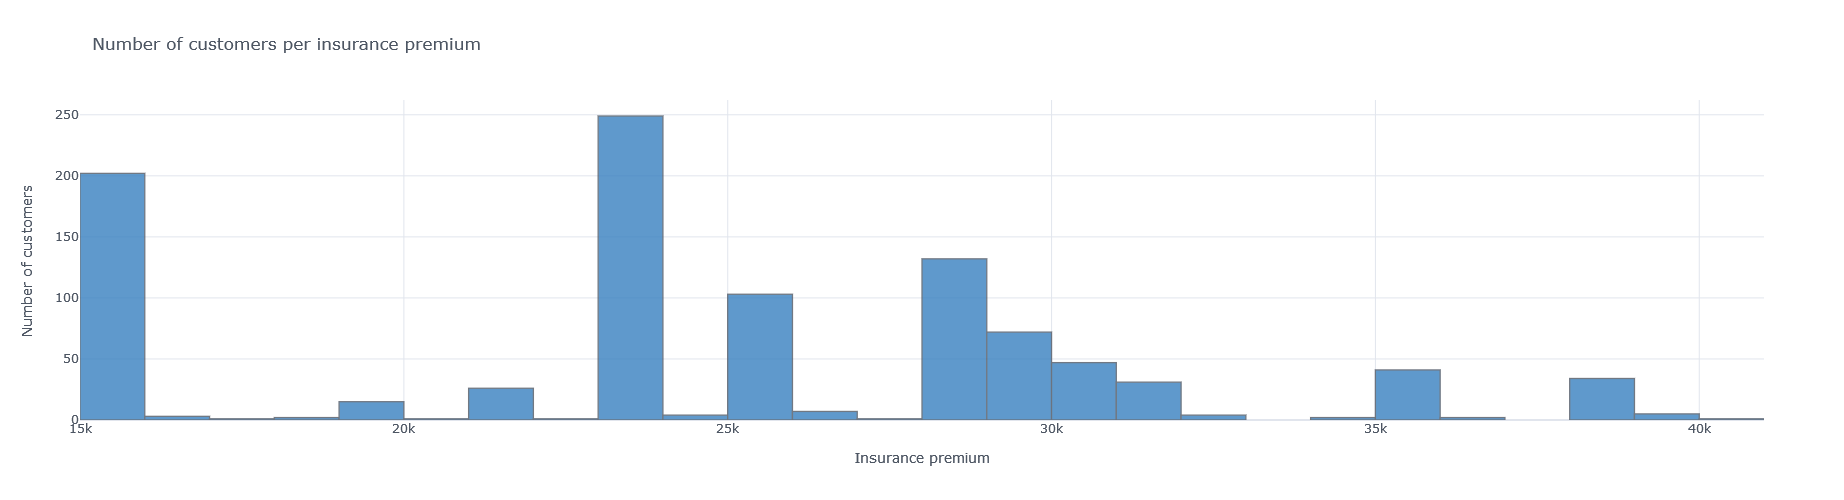

count      986.000000
mean     24336.713996
std       6248.184382
min      15000.000000
25%      21000.000000
50%      23000.000000
75%      28000.000000
max      40000.000000
Name: PremiumPrice, dtype: float64

In [52]:
data['PremiumPrice'].iplot(kind = 'histogram', dimensions = (800,500), 
                           xTitle = 'Insurance premium', yTitle = 'Number of customers',
                           title = 'Number of customers per insurance premium', color = '#3780BF')

data['PremiumPrice'].describe()

The vast majority of customers is under the age of 53, the average customer age is 42 years.

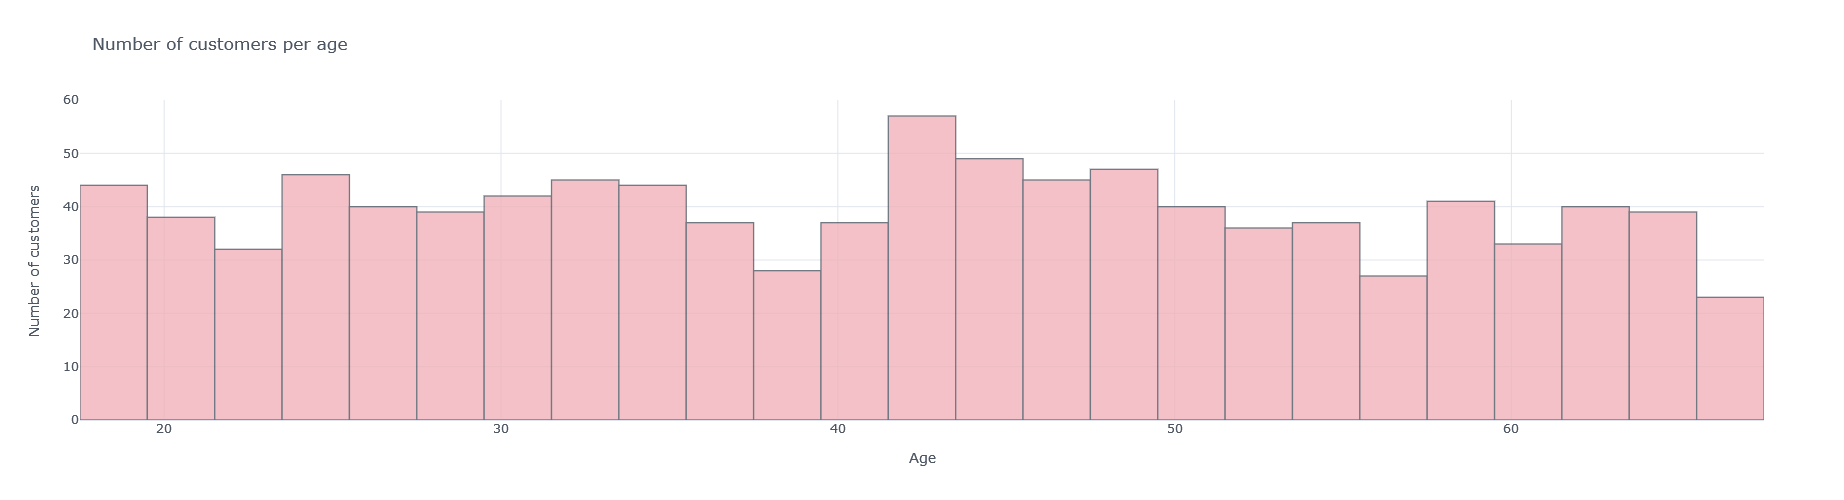

count    986.000000
mean      41.745436
std       13.963371
min       18.000000
25%       30.000000
50%       42.000000
75%       53.000000
max       66.000000
Name: Age, dtype: float64

In [53]:
data['Age'].iplot(kind = 'histogram', dimensions = (800,500), 
                  xTitle = 'Age', yTitle = 'Number of customers', 
                  title = 'Number of customers per age', color = '#F0B2B9')

data['Age'].describe()

In general, we can say that there is positive correlation between age of customer and insurance premium. A substantial number of outliers can be explained by extremely different health history.

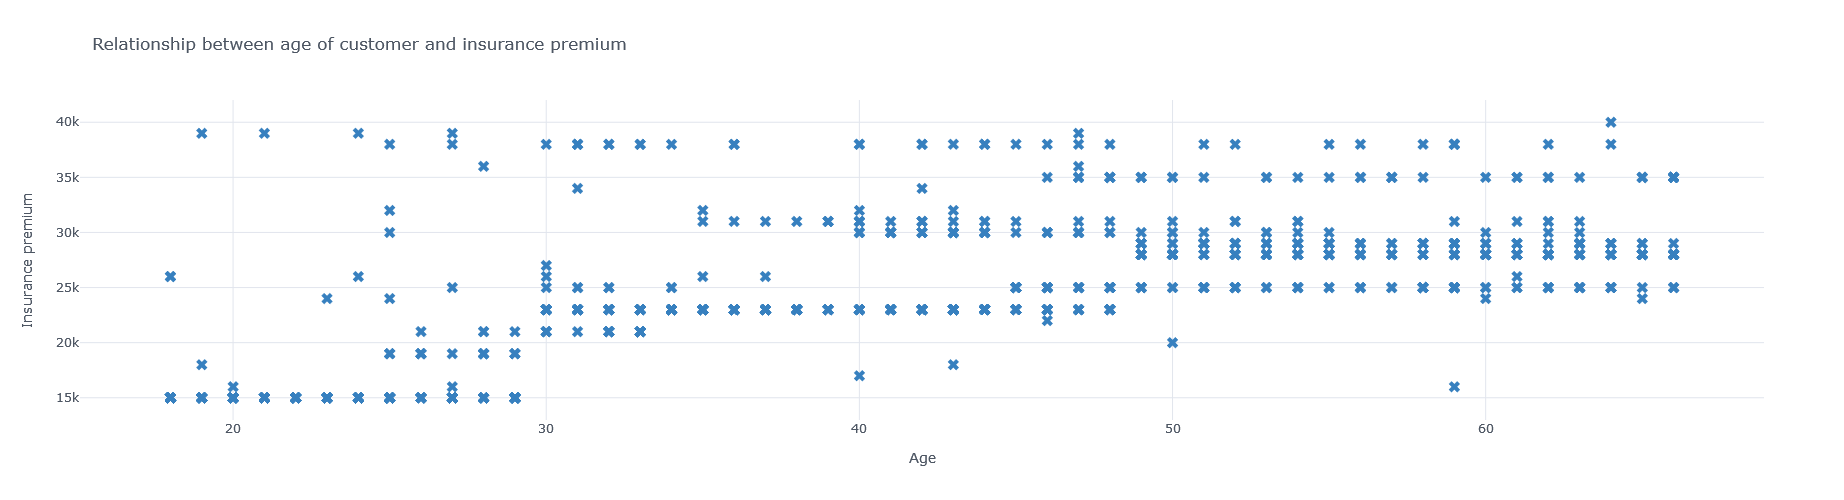

In [54]:
data.iplot(kind = 'scatter', 
           x = 'Age', y = 'PremiumPrice',  dimensions = (800,500), 
           mode = 'markers', size=10, symbol='x', color = '#3780BF', 
           xTitle = 'Age', yTitle = 'Insurance premium', 
           title = 'Relationship between age of customer and insurance premium')

For better clarity, we calculate the mean insurance costs per age. As you can see in the charts above, young people under the age of 30 pay, on average, a much lower insurance premium.

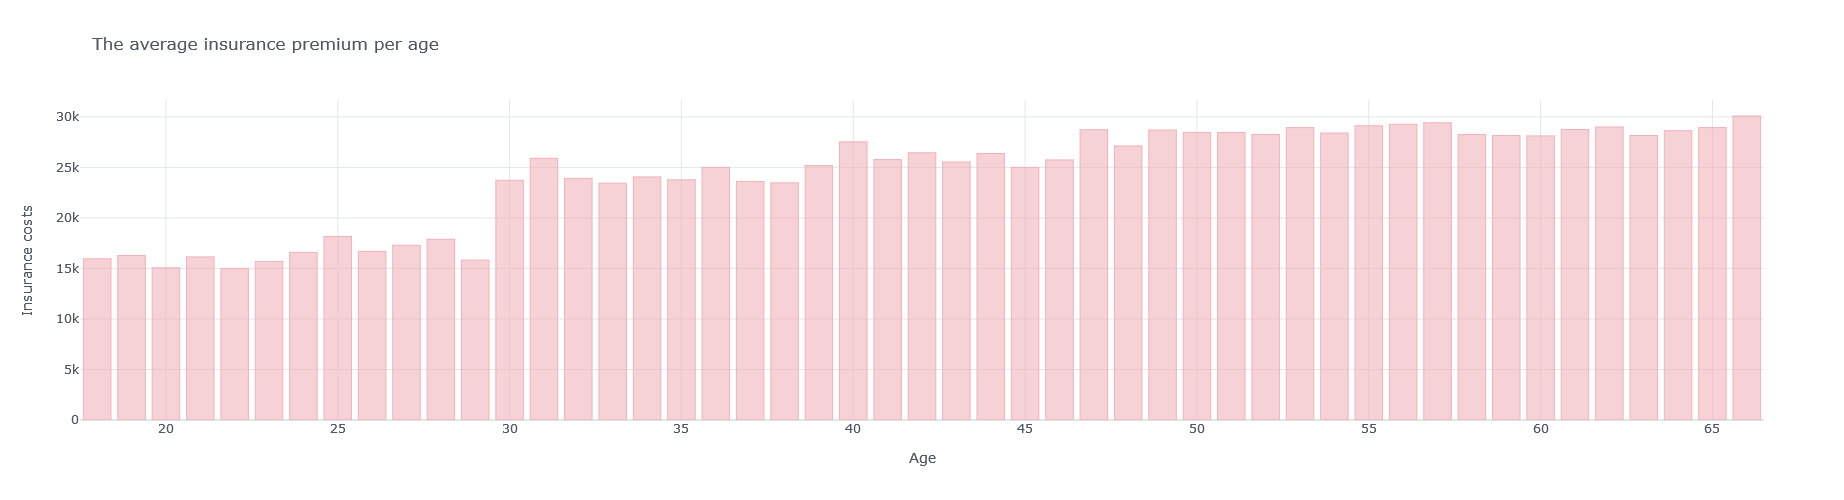

In [55]:
avg_premium_per_age = data[['Age', 'PremiumPrice']].groupby(by = ['Age']).mean()
avg_premium_per_age.iplot(kind = 'bar', y = 'PremiumPrice', dimensions = (800,500), 
                          xTitle = 'Age', yTitle = 'Insurance costs', 
                          title = 'The average insurance premium per age', color = '#F0B2B9')

To avoid possible misconception let's run formal test. Owing to non-normal distribution of 'PremiumPrice' variable, we check the strength of the link using Spearman's rank correlation coefficient. And indeed, we observe a strong correlation between insurance costs and age of customer (p < 0.001).

In [56]:
pg.corr(data['Age'], data['PremiumPrice'], method = 'spearman')

,n,r,CI95%,p-val,power
spearman,986,0.739088,"[0.71, 0.77]",4.892783e-171,1.0


58% of customers have abnormal blood sugar levels and their median insurance costs are ₹2,000 higher, but less spread out (p = 0.006).

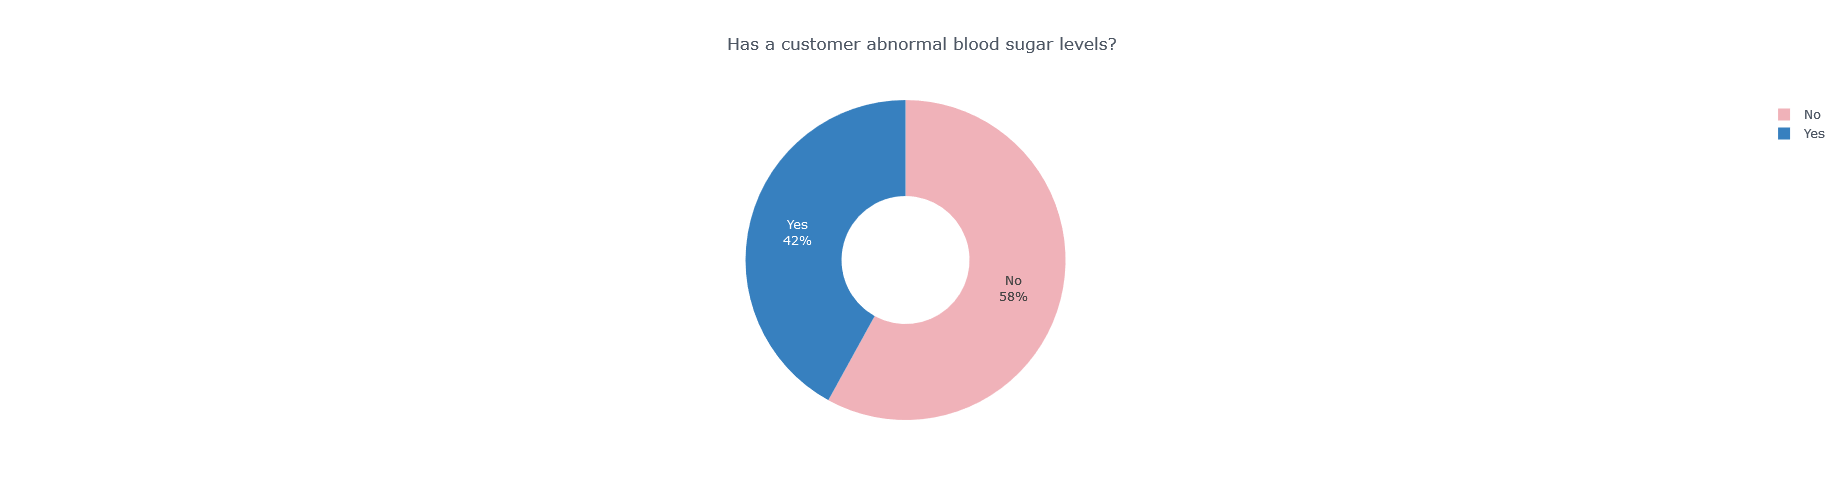

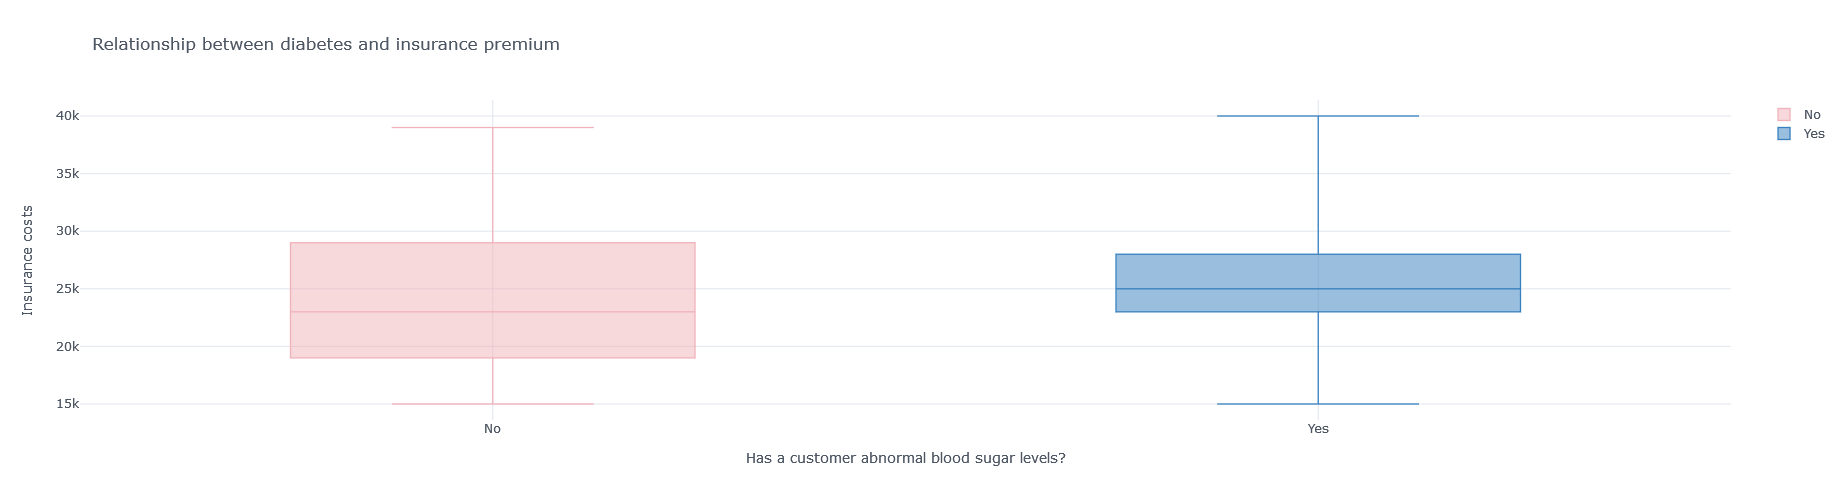

In [57]:
data_diabetes = data.groupby(by = ['Diabetes']).count()[['Age']].rename(columns={'Age':'Count'}).reset_index()
data_diabetes['Diabetes'] = data_diabetes['Diabetes'].replace({0:'No', 1:'Yes'})
data_diabetes.iplot(kind = 'pie', 
                    labels = 'Diabetes', 
                    values = 'Count', 
                    textinfo = 'percent+label', hole=.4,
                    dimensions = (800,500), 
                    colors = ['#F0B2B9', '#3780BF'], title = 'Has a customer abnormal blood sugar levels?'
                    )

data1 = data.copy()
data1['Diabetes'] = data1['Diabetes'].replace({0:'No', 1:'Yes'})
data1[['Diabetes', 'PremiumPrice']].pivot(columns = 'Diabetes', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                               xTitle = 'Has a customer abnormal blood sugar levels?', yTitle = 'Insurance costs', 
                                                                                               title = 'Relationship between diabetes and insurance premium', colors = ['#F0B2B9', '#3780BF'])

In [58]:
kruskal(data, dv = 'PremiumPrice', between = 'Diabetes')

,Source,ddof1,H,p-unc
Kruskal,Diabetes,1,7.412192,0.006478


We see the identical results in case of blood pressure.

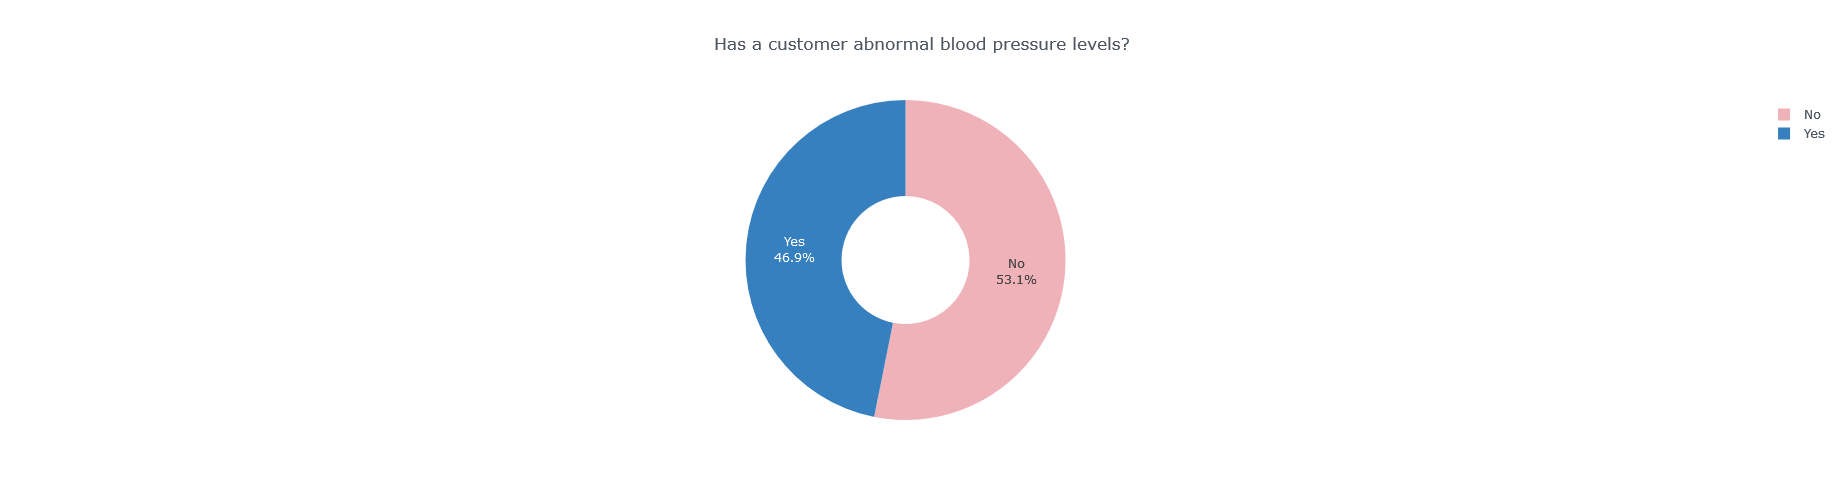

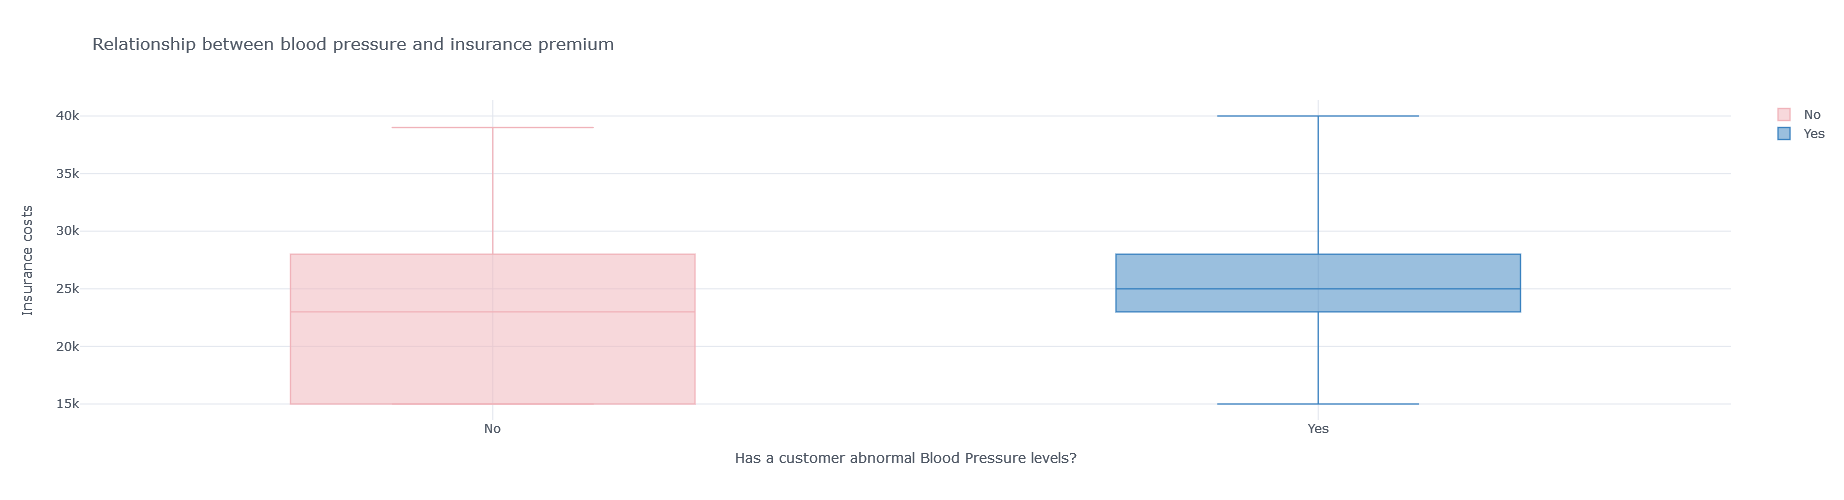

In [60]:
data_blood = data.groupby(by = ['BloodPressureProblems']).count()[['Age']].rename(columns = {'Age':'Count'}).reset_index()
data_blood['BloodPressureProblems'] = data_blood['BloodPressureProblems'].replace({0:'No', 1:'Yes'})
data_blood.iplot(kind = 'pie', 
                 labels = 'BloodPressureProblems', 
                 values = 'Count', 
                 textinfo = 'percent+label', hole=.4, 
                 dimensions = (800,500), 
                 colors = ['#F0B2B9', '#3780BF'], title = 'Has a customer abnormal blood pressure levels?'
                 )

data2 = data.copy()
data2['BloodPressureProblems'] = data2['BloodPressureProblems'].replace({0:'No', 1:'Yes'})
data2[['BloodPressureProblems', 'PremiumPrice']].pivot(columns = 'BloodPressureProblems', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                                         xTitle = 'Has a customer abnormal Blood Pressure levels?', yTitle = 'Insurance costs', 
                                                                                                                         title = 'Relationship between blood pressure and insurance premium', 
                                                                                                                         colors = ['#F0B2B9', '#3780BF'])

In [61]:
kruskal(data, dv = 'PremiumPrice', between = 'BloodPressureProblems')

,Source,ddof1,H,p-unc
Kruskal,BloodPressureProblems,1,30.656359,3.080155e-08


Only a small percentage of customers (5.58%) have had organ transplants. Nevertheless, there is a statistically significant relationship between transplantation and insurance costs (p < 0.001).

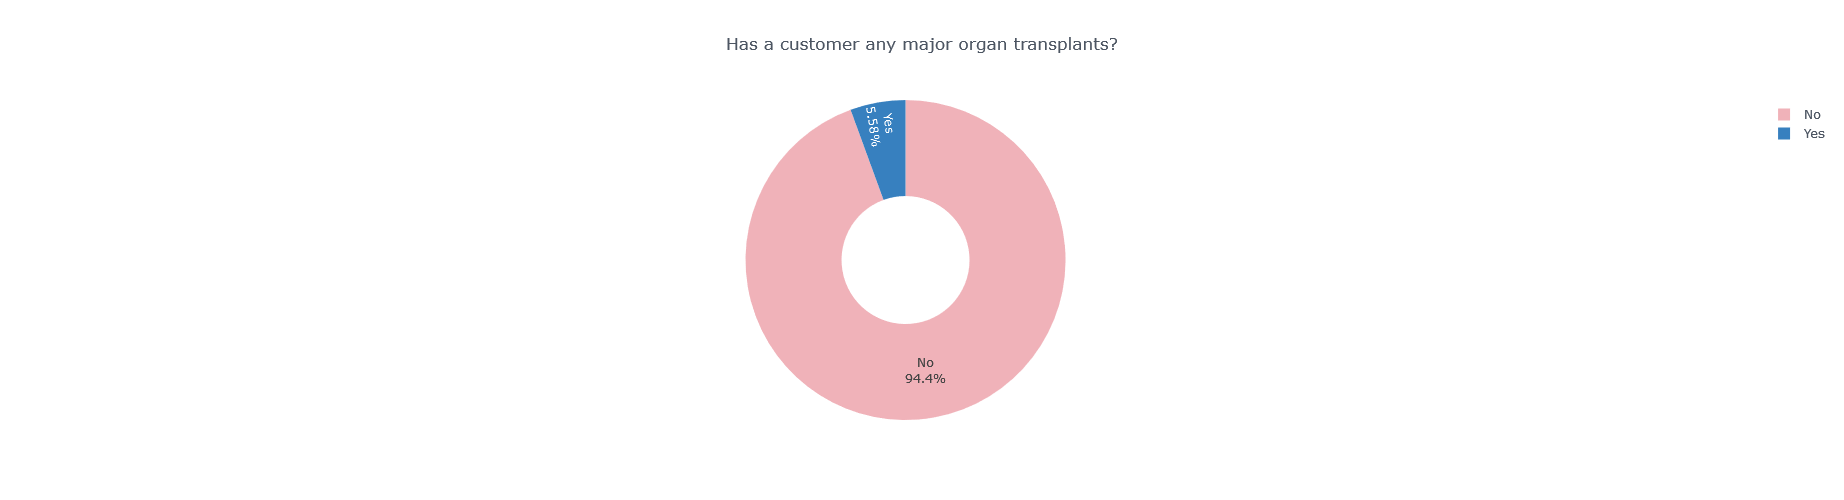

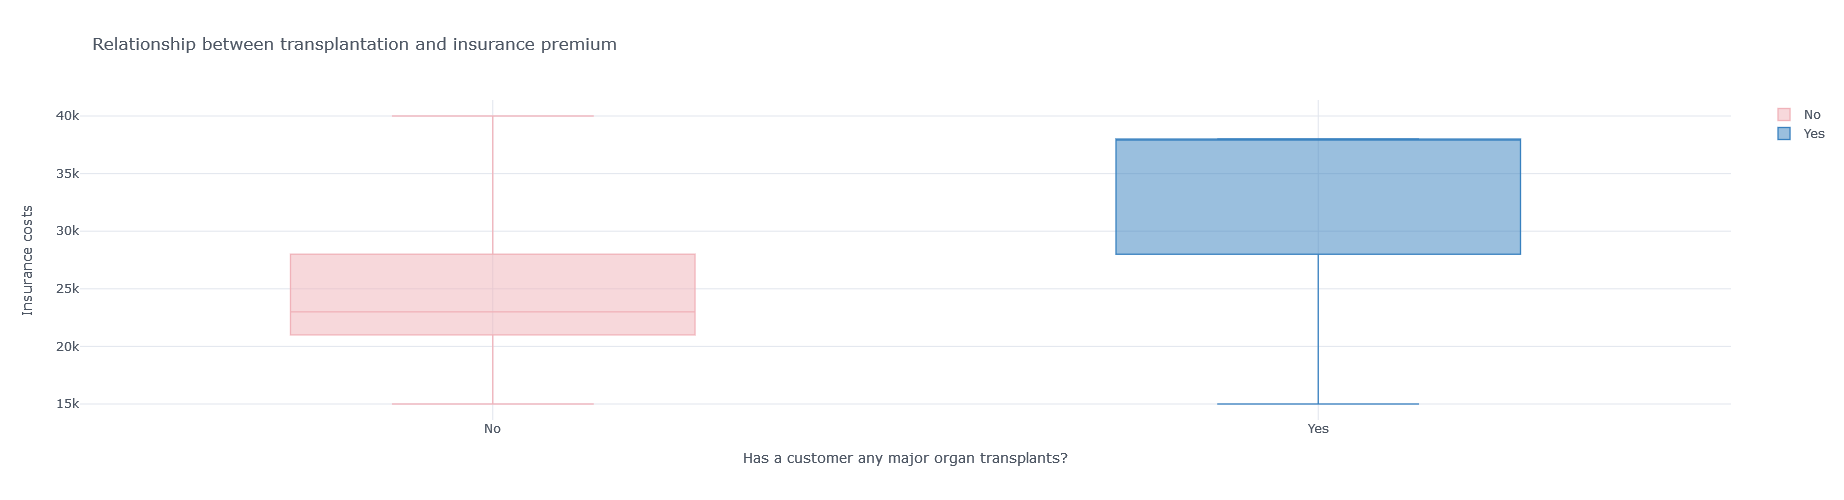

In [62]:
data_transplants = data.groupby(by = ['AnyTransplants']).count()[['Age']].rename(columns={'Age':'Count'}).reset_index()
data_transplants['AnyTransplants'] = data_transplants['AnyTransplants'].replace({0:'No', 1:'Yes'})
data_transplants.iplot(kind = 'pie', 
                       labels = 'AnyTransplants', 
                       values = 'Count', 
                       textinfo = 'percent+label', hole=.4, 
                       dimensions = (800,500), 
                       colors = ['#F0B2B9', '#3780BF'], title = 'Has a customer any major organ transplants?'
                       )

data3 = data.copy()
data3['AnyTransplants'] = data3['AnyTransplants'].replace({0:'No', 1:'Yes'})
data3[['AnyTransplants', 'PremiumPrice']].pivot(columns = 'AnyTransplants', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                           xTitle = 'Has a customer any major organ transplants?', yTitle = 'Insurance costs', 
                                                                                                           title = 'Relationship between transplantation and insurance premium', colors = ['#F0B2B9', '#3780BF']) 

In [63]:
kruskal(data, dv = 'PremiumPrice', between = 'AnyTransplants')

,Source,ddof1,H,p-unc
Kruskal,AnyTransplants,1,46.486259,9.226317e-12


Most of the customers (81.9%) don't have any chronic diseases and usually pay less premium (p < 0.001).

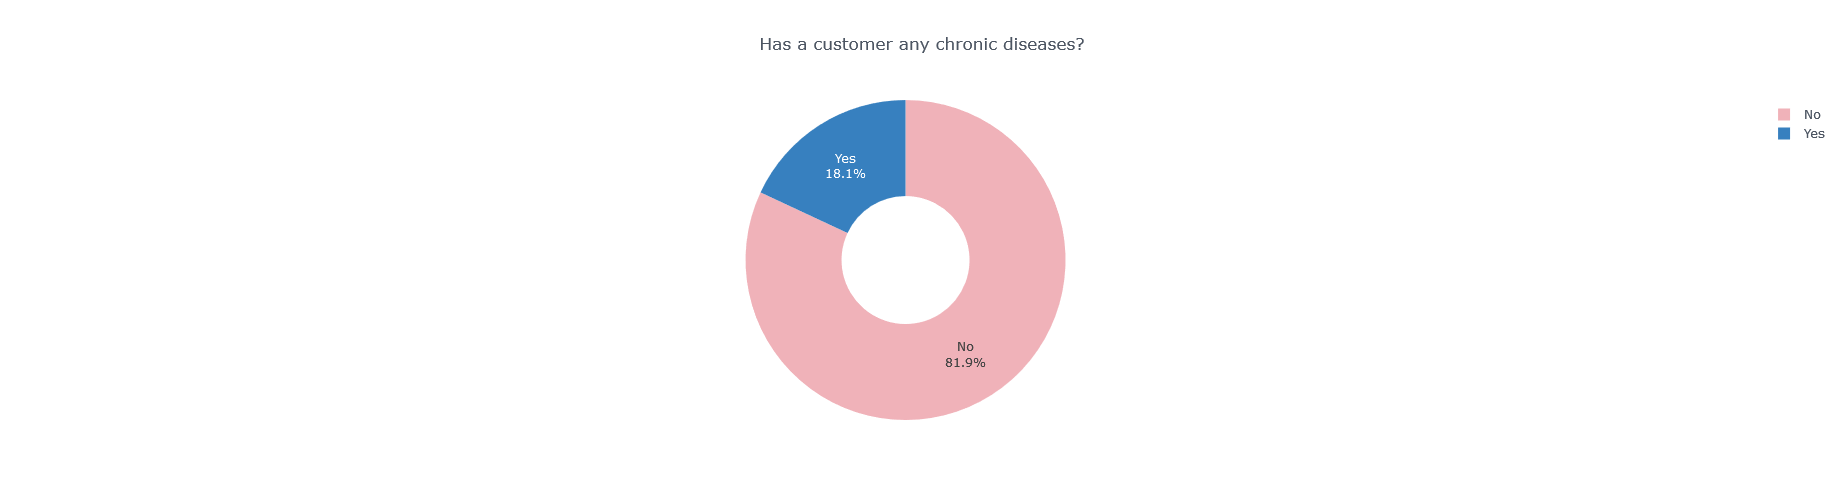

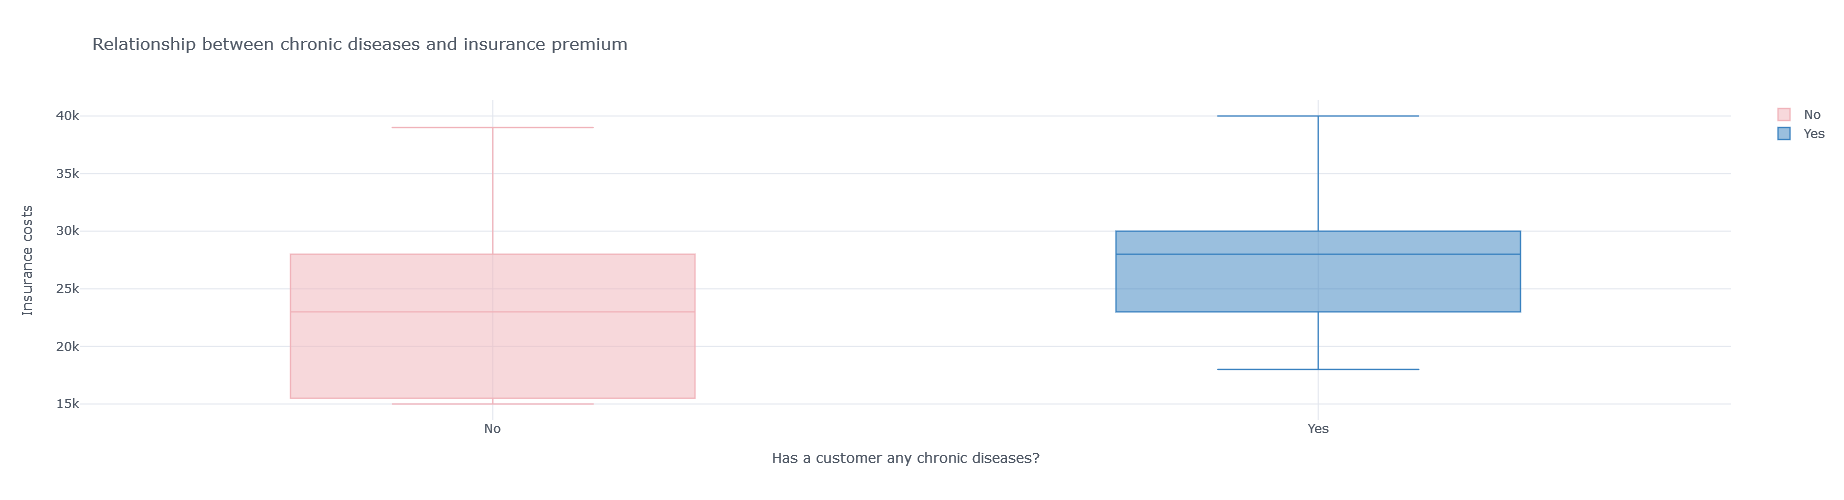

In [64]:
data_chronic = data.groupby(by = ['AnyChronicDiseases']).count()[['Age']].rename(columns = {'Age':'Count'}).reset_index()
data_chronic['AnyChronicDiseases'] = data_chronic['AnyChronicDiseases'].replace({0:'No', 1:'Yes'})
data_chronic.iplot(kind = 'pie', 
                   labels = 'AnyChronicDiseases', 
                   values = 'Count', 
                   textinfo = 'percent+label', hole=.4, 
                   dimensions = (800,500), 
                   colors = ['#F0B2B9', '#3780BF'], title = 'Has a customer any chronic diseases?' 
                   )

data4 = data.copy()
data4['AnyChronicDiseases'] = data4['AnyChronicDiseases'].replace({0:'No', 1:'Yes'})
data4[['AnyChronicDiseases', 'PremiumPrice']].pivot(columns = 'AnyChronicDiseases', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                                   xTitle = 'Has a customer any chronic diseases?', yTitle = 'Insurance costs', 
                                                                                                                   title = 'Relationship between chronic diseases and insurance premium', 
                                                                                                                   colors = ['#F0B2B9', '#3780BF'])

In [65]:
kruskal(data, dv = 'PremiumPrice', between = 'AnyChronicDiseases')

,Source,ddof1,H,p-unc
Kruskal,AnyChronicDiseases,1,44.731878,2.259486e-11


78.5% of customers indicated that they don't have any known allergies. Our analysis don't revealed the link between allergies and insurance premium (p = 0.566).

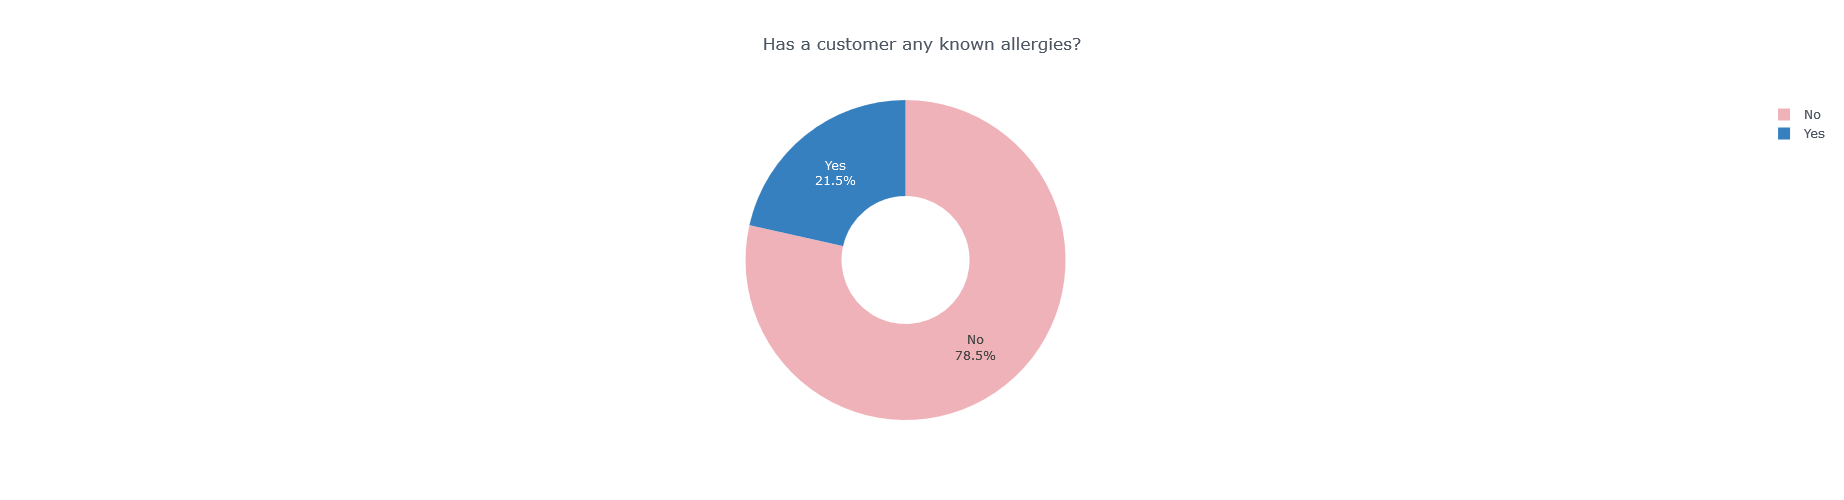

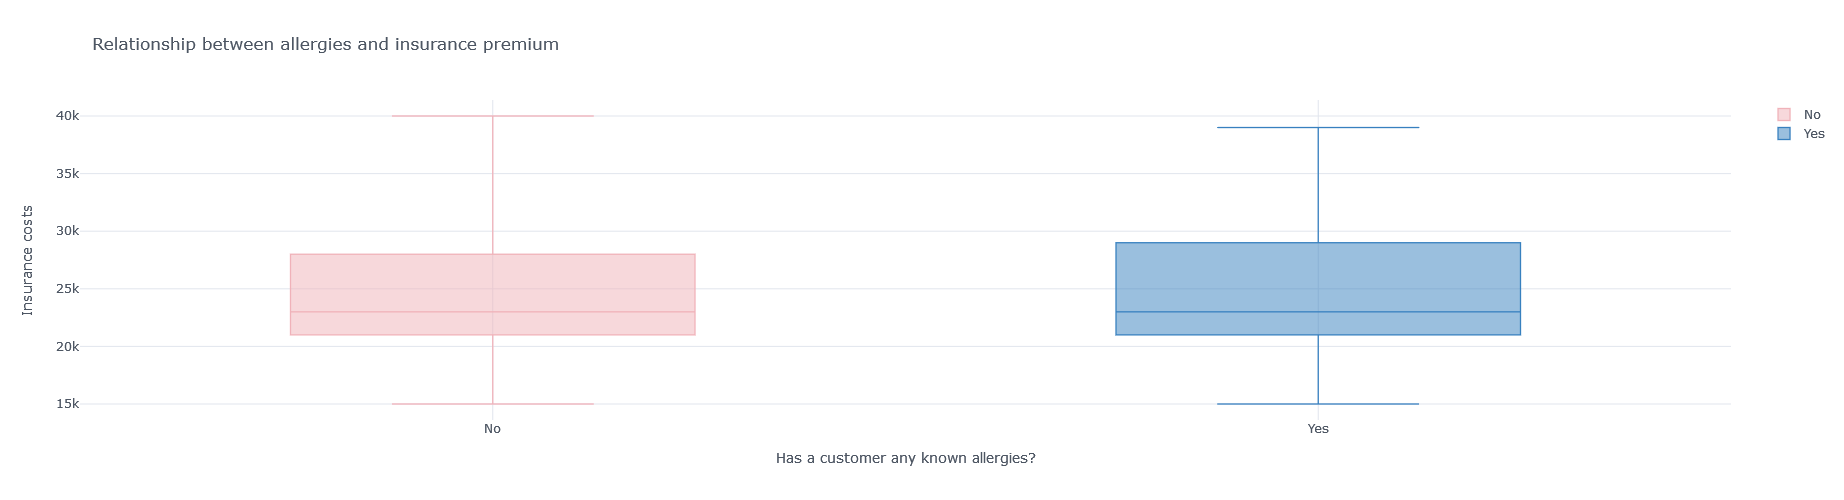

In [66]:
data_allergies = data.groupby(by = ['KnownAllergies']).count()[['Age']].rename(columns = {'Age':'Count'}).reset_index()
data_allergies['KnownAllergies'] = data_allergies['KnownAllergies'].replace({0:'No', 1:'Yes'})
data_allergies.iplot(kind = 'pie', 
                     labels = 'KnownAllergies', 
                     values = 'Count', 
                     textinfo = 'percent+label', hole=.4, 
                     dimensions = (800,500), 
                     colors = ['#F0B2B9', '#3780BF'], title = 'Has a customer any known allergies?' 
                     )

data5 = data.copy()
data5['KnownAllergies'] = data5['KnownAllergies'].replace({0:'No', 1:'Yes'})
data5[['KnownAllergies', 'PremiumPrice']].pivot(columns = 'KnownAllergies', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                           xTitle = 'Has a customer any known allergies?', yTitle = 'Insurance costs', 
                                                                                                           title = 'Relationship between allergies and insurance premium', 
                                                                                                           colors = ['#F0B2B9', '#3780BF'])

In [67]:
kruskal(data, dv = 'PremiumPrice', between = 'KnownAllergies')

,Source,ddof1,H,p-unc
Kruskal,KnownAllergies,1,0.329947,0.56569


11.8% of consumers have one or more family members suffered or suffer from cancer and their median insurance costs are ₹5,000 higher (p < 0.001).

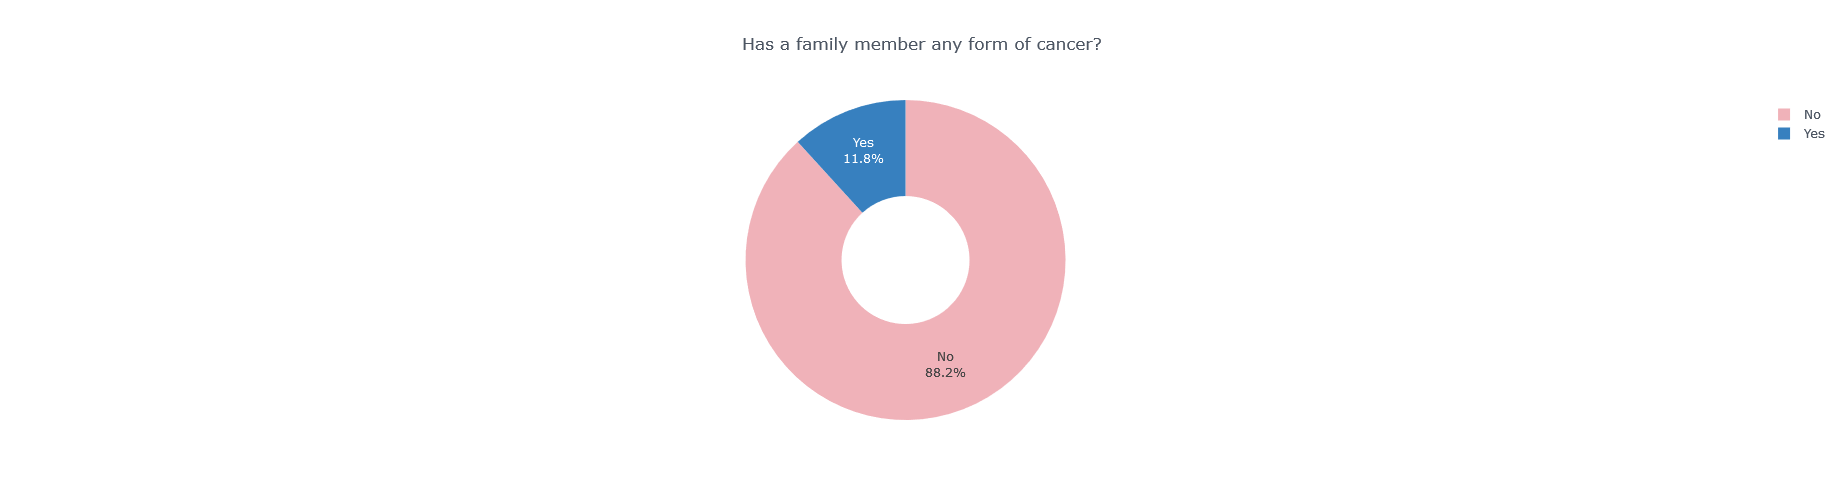

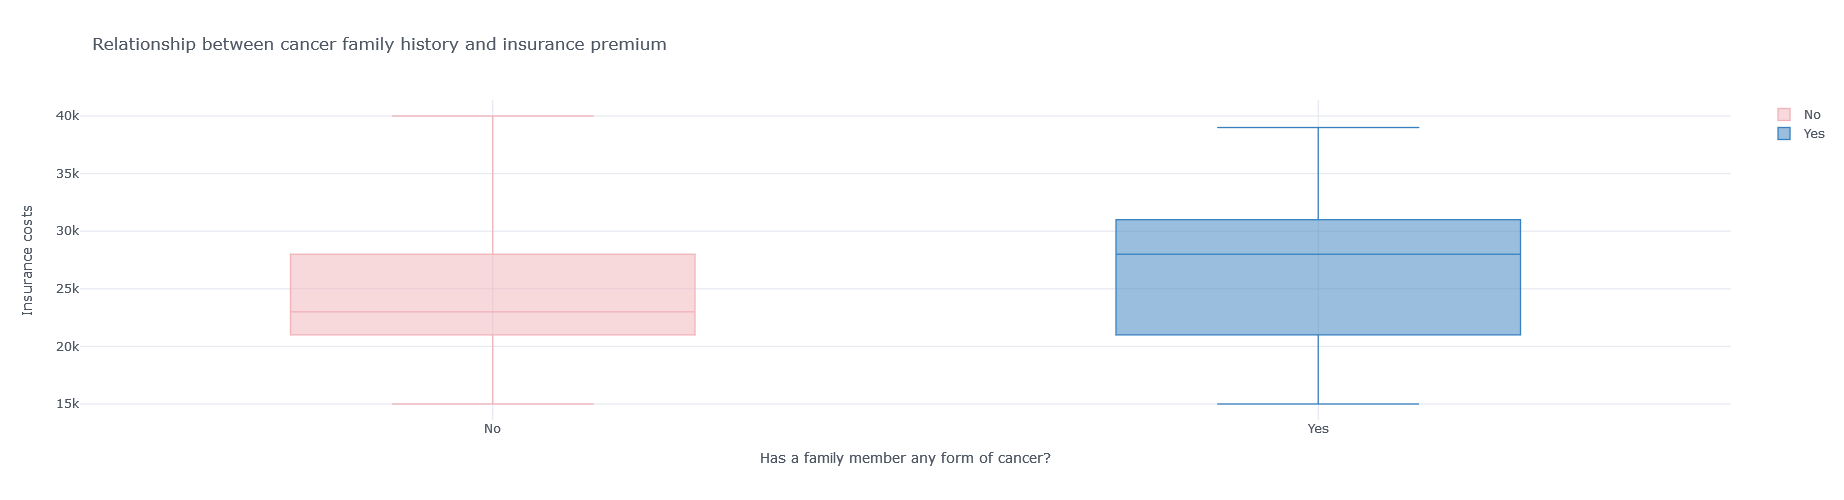

In [68]:
data_cancer = data.groupby(by = ['HistoryOfCancerInFamily']).count()[['Age']].rename(columns = {'Age':'Count'}).reset_index()
data_cancer['HistoryOfCancerInFamily'] = data_cancer['HistoryOfCancerInFamily'].replace({0:'No', 1:'Yes'})
data_cancer.iplot(kind = 'pie', 
                 labels = 'HistoryOfCancerInFamily', 
                 values = 'Count', 
                 textinfo = 'percent+label', hole=.4, 
                 dimensions = (800,500), 
                 colors = ['#F0B2B9', '#3780BF'], title = 'Has a family member any form of cancer?'
                 )

data6 = data.copy()
data6['HistoryOfCancerInFamily'] = data6['HistoryOfCancerInFamily'].replace({0:'No', 1:'Yes'})
data6[['HistoryOfCancerInFamily', 'PremiumPrice']].pivot(columns = 'HistoryOfCancerInFamily', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                                             xTitle = 'Has a family member any form of cancer?', yTitle = 'Insurance costs', 
                                                                                                                             title = 'Relationship between cancer family history and insurance premium', 
                                                                                                                             colors = ['#F0B2B9', '#3780BF'])

In [69]:
kruskal(data, dv = 'PremiumPrice', between = 'HistoryOfCancerInFamily')

,Source,ddof1,H,p-unc
Kruskal,HistoryOfCancerInFamily,1,15.14097,0.0001


The majority of customers have had either none or just one major surgery (48,6 and 37.7% correspondingly). The fact of a surgery in the past itself shows a positive correlation with insurance premium. However, there is no significant difference in median costs for customers with two and three medical interventions. 

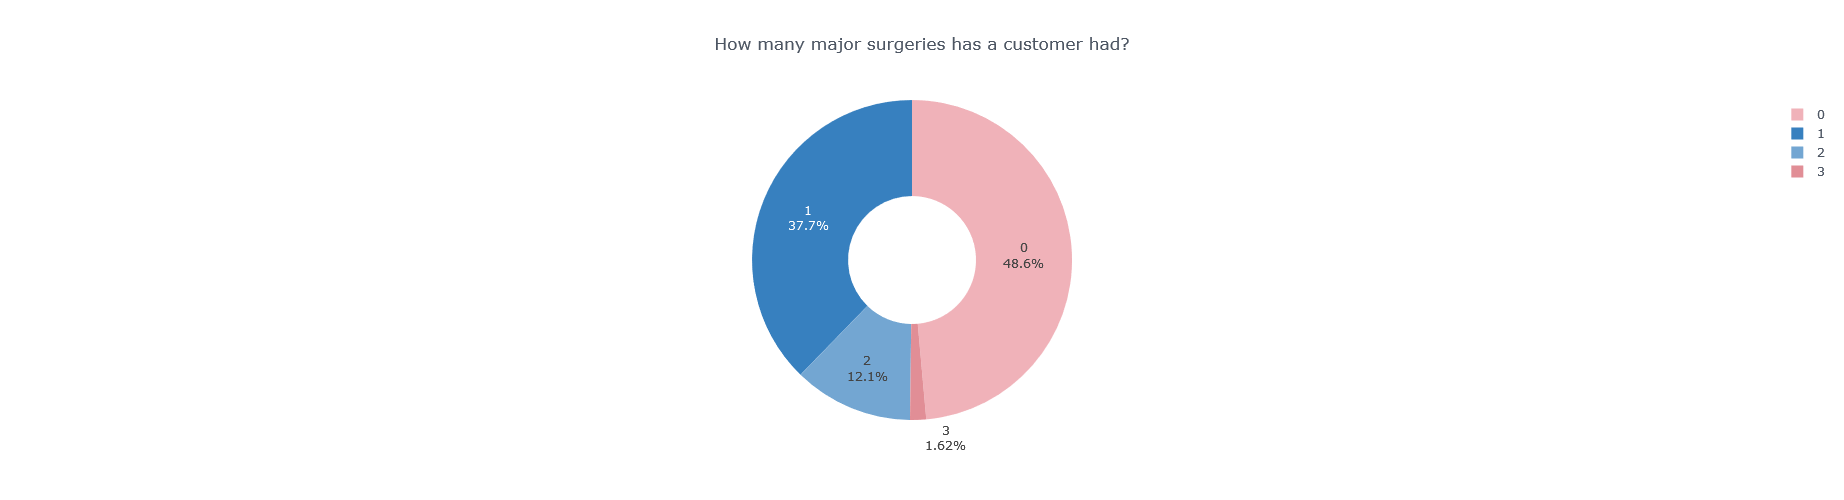

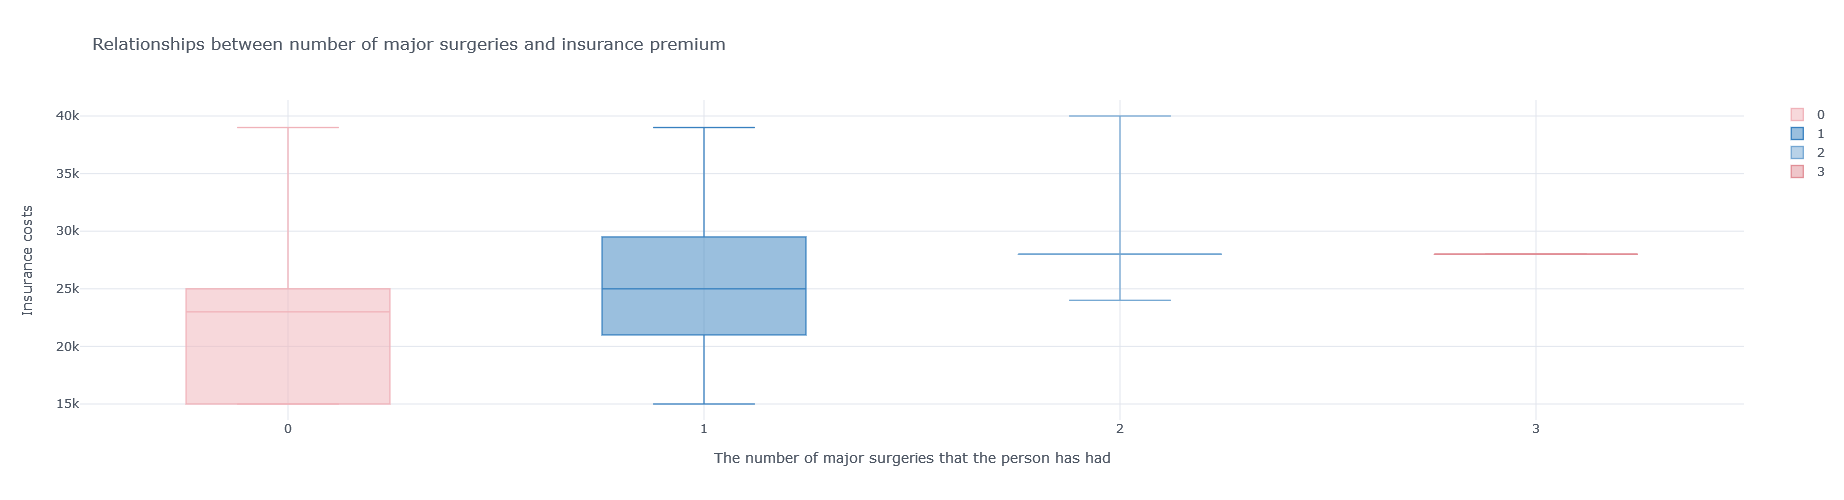

In [70]:
data_surgeries = data.groupby(by = ['NumberOfMajorSurgeries']).count()[['Age']].rename(columns = {'Age':'Count'}).reset_index()
data_surgeries.iplot(kind = 'pie', 
                     labels = 'NumberOfMajorSurgeries', 
                     values = 'Count', 
                     textinfo = 'percent+label', hole=.4, 
                     dimensions = (800,500), 
                     colors = ['#F0B2B9', '#3780BF', '#73A6D2', '#e18e96'], title = 'How many major surgeries has a customer had?' 
                     )


data[['NumberOfMajorSurgeries', 'PremiumPrice']].pivot(columns = 'NumberOfMajorSurgeries', values = 'PremiumPrice').iplot(kind = 'box', dimensions = (800,500), 
                                                                                                                          xTitle = 'The number of major surgeries that the person has had', yTitle = 'Insurance costs', 
                                                                                                                          title = 'Relationships between number of major surgeries and insurance premium', 
                                                                                                                          colors = ['#F0B2B9', '#3780BF', '#73A6D2', '#e18e96'])

In [71]:
kruskal(data, dv = 'PremiumPrice', between = 'NumberOfMajorSurgeries')

,Source,ddof1,H,p-unc
Kruskal,NumberOfMajorSurgeries,3,93.812771,3.322341e-20


In [72]:
sp.posthoc_conover(data, val_col = 'PremiumPrice', group_col = 'NumberOfMajorSurgeries', p_adjust = 'holm')

,0,1,2,3
0,1.000000e+00,3.946543e-06,8.664163e-20,0.000467
1,3.946543e-06,1.000000e+00,1.268572e-08,0.029261
2,8.664163e-20,1.268572e-08,1.000000e+00,0.972980
3,4.673231e-04,2.926093e-02,9.729802e-01,1.000000


There are 38 underweight persons, 318 customers have a normal weight and others - overweight. The distribution is positively skewed: most of the customers have BMI of less than 30.8 kg/m², but we can notice 
a long right tail of much more higher BMI (the highest Body Mass Index is 50 kg/m²).


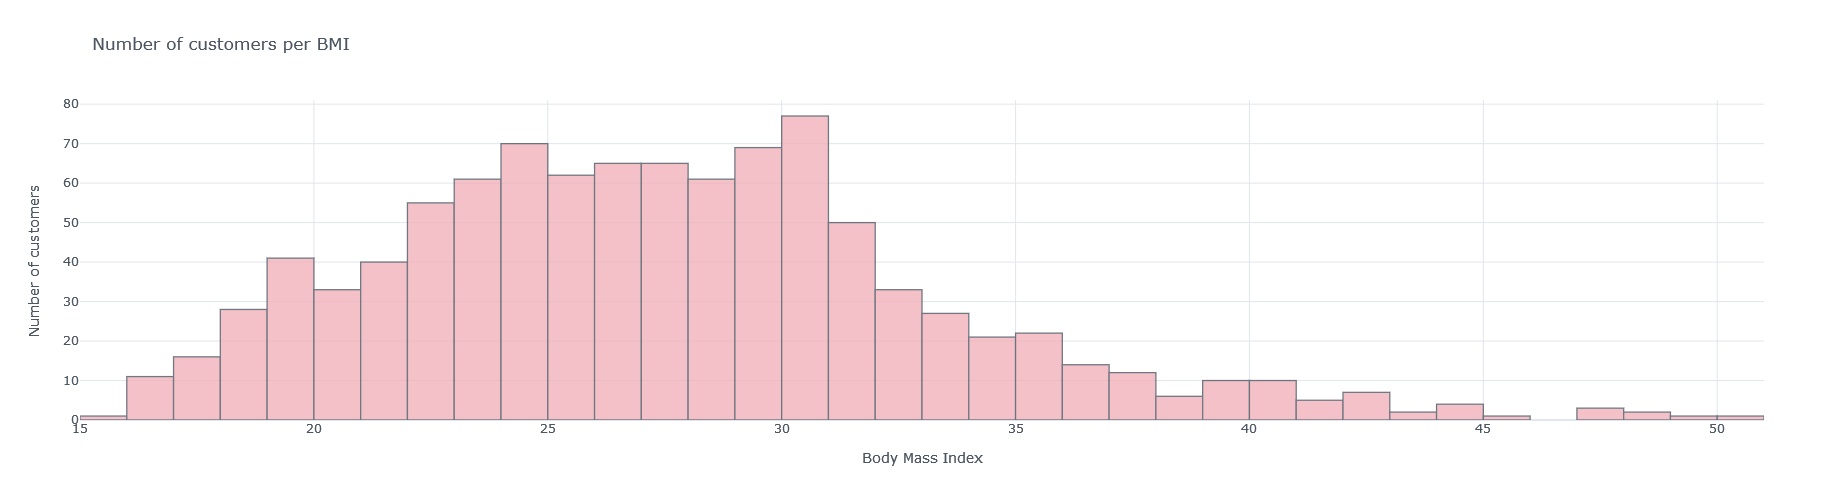

count    986.000000
mean      27.460041
std        5.879494
min       15.200000
25%       23.400000
50%       27.200000
75%       30.800000
max       50.000000
Name: BMI, dtype: float64

In [73]:
data['BMI'].iplot(kind = 'histogram', dimensions = (800,500), 
                  xTitle = 'Body Mass Index', yTitle = 'Number of customers',
                  title = 'Number of customers per BMI', color = '#F0B2B9')

data['BMI'].describe()

There is a very weak link between Body Mass Index and insurance premium among customers (p = 0.002).

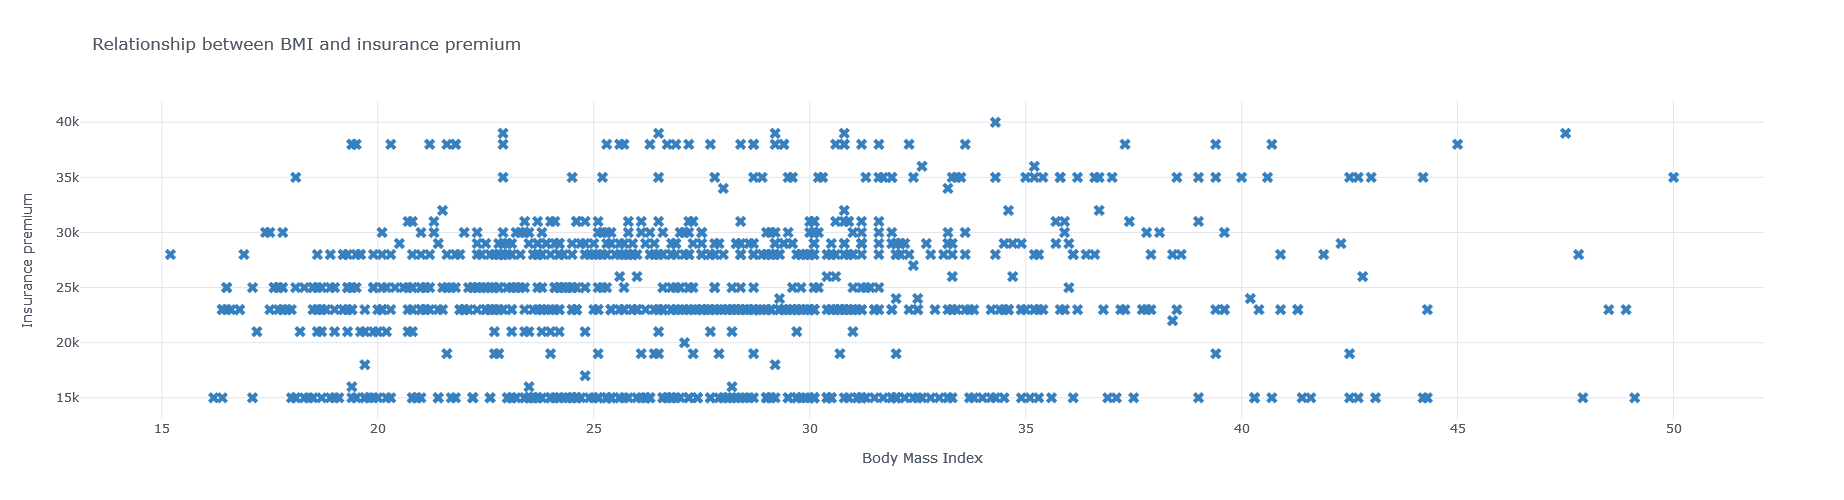

In [74]:
data.iplot(kind = 'scatter', 
           x = 'BMI', y = 'PremiumPrice',  dimensions = (800,500), 
           mode = 'markers', size=10, symbol='x', color = '#3780BF', 
           xTitle = 'Body Mass Index', yTitle = 'Insurance premium',
           title = 'Relationship between BMI and insurance premium')

In [75]:
pg.corr(data['BMI'], data['PremiumPrice'], method = 'spearman')

,n,r,CI95%,p-val,power
spearman,986,0.098337,"[0.04, 0.16]",0.001992,0.871726


Thus, age, transplanted organ and tissue status and the existence of the chronic disease play an important role in determining the insurance costs, whereas the link between allergies and insurance premium is not found.

<h2>Methodology and analysis</h2>

Let's try to predict insurance costs. This topic is a matter of a regression analysis. Common machine learning algorithms that can be used for this task include: 

- Linear Regression;
- Ridge Regression;
- Lasso Regression; 
- Decision Tree Regression;
- Random Forest.

Before proceeding to the models and algorithms, we should split our dataset into training (90%) and testing (10%) sets.

In [77]:
X = data.drop('PremiumPrice',axis=1)
Y = data['PremiumPrice']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=115)

Variables that are measured at different scales do not contribute equally to the model fitting and model learned function and might end up creating a bias. Thus, to deal with this potential problem we should standardized our features. 

In [78]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Accuracy of the multiple linear regression is mediocre and attempt to regularize coefficients using Ridge and lasso regression failed.

In [79]:
reg = LinearRegression()
reg.fit(X_train, Y_train)
print('Accuracy of the linear regression model (training set) ',round(reg.score(X_train,Y_train), 4))
print('Accuracy of the linear regression model (test set) ',round(reg.score(X_test,Y_test), 4))

Accuracy of the linear regression model (training set)  0.6328
Accuracy of the linear regression model (test set)  0.6572


In [80]:
reg_ridge = Ridge()
reg_ridge.fit(X_train, Y_train)
print('Accuracy of Ridge regression model (training set) ',round(reg_ridge.score(X_train,Y_train), 4))
print('Accuracy of Ridge regression model (test set) ',round(reg_ridge.score(X_test,Y_test), 4))

Accuracy of Ridge regression model (training set)  0.6328
Accuracy of Ridge regression model (test set)  0.6574


In [81]:
reg_lasso = Lasso()
reg_lasso.fit(X_train, Y_train)
print('Accuracy of Lasso regression model (training set) ',round(reg_lasso.score(X_train,Y_train), 4))
print('Accuracy of Lasso regression model (test set) ',round(reg_lasso.score(X_test,Y_test), 4))

Accuracy of Lasso regression model (training set)  0.6328
Accuracy of Lasso regression model (test set)  0.6573


Applying decision tree method to our regression problem, we were faced with overfitting (the model matches the training data perfectly, but does poorly in validation).

In [82]:
reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, Y_train)
print('Accuracy of the desicion tree model (training set) ',round(reg_tree.score(X_train,Y_train), 4))
print('Accuracy of the desicion tree model (test set) ',round(reg_tree.score(X_test,Y_test), 4))

Accuracy of the desicion tree model (training set)  1.0
Accuracy of the desicion tree model (test set)  0.421


To insure the best performance of the model, we tune the hyperparameters using random search method.

In [83]:
param_dict = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': range(1,10), 
              'min_samples_split': range(2,5), 
              'min_samples_leaf': range(1,5)}

tree_random = RandomizedSearchCV(estimator = reg_tree, 
                                 param_distributions = param_dict, 
                                 scoring = 'neg_root_mean_squared_error', 
                                 n_iter = 10, cv = 5, verbose = 2, 
                                 random_state = 42, n_jobs = 1)

tree_random.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_feat

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=1,
                   param_distributions={'max_depth': range(1, 10),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 5)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [84]:
tree_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 4}

In [85]:
tree_random.best_estimator_

DecisionTreeRegressor(max_depth=4, max_features='auto')

Great, the model shows 76.5% accuracy and by this notebly outperforming previously used models.

In [86]:
reg_tree = DecisionTreeRegressor(max_depth = 4, max_features = 'auto')
reg_tree.fit(X_train, Y_train)
Y_pred = reg_tree.predict(X_test)
print('Accuracy of the decision tree model after tuning hyperparameters (training set) ',round(reg_tree.score(X_train,Y_train), 4))
print('Accuracy of the desicion tree model after tuning hyperparameters (test set) ',round(reg_tree.score(X_test,Y_test), 4))

Accuracy of the decision tree model after tuning hyperparameters (training set)  0.7707
Accuracy of the desicion tree model after tuning hyperparameters (test set)  0.765


Let’s try to achieve more adequate predictions using an another model - Random Forest. Here, we again observe overfitting.

In [87]:
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, Y_train)
y_pred = reg_rf.predict(X_test)
print('Accuracy of Random Forest model (training set) ',round(reg_rf.score(X_train,Y_train), 4))
print('Accuracy of Random Forest model (test set) ',round(reg_rf.score(X_test, Y_test), 4))

Accuracy of Random Forest model (training set)  0.9635
Accuracy of Random Forest model (test set)  0.8136


In the case of a random forest, hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node.

In [88]:
param_dict = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 
              'max_features': ['auto', 'sqrt'], 
              'max_depth': range(1,10), 
              'min_samples_split': range(2,5), 
              'min_samples_leaf': range(1,5)}

rf_random = RandomizedSearchCV(estimator = reg_rf, 
                               param_distributions = param_dict,
                               scoring = 'neg_root_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose = 2, 
                               random_state = 42, n_jobs = 1)

rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total 

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': range(1, 10),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 5),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [89]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 6}

In [90]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=900)

Using Random Forest technique we achieved 86.02% accuracy on test set.

In [91]:
reg_rf = RandomForestRegressor(max_depth = 6, min_samples_leaf = 2, n_estimators = 900)
reg_rf.fit(X_train, Y_train)
y_pred = reg_rf.predict(X_test)
print('Accuracy of Random Forest model after tuning hyperparameters (training set) ',round(reg_rf.score(X_train,Y_train), 4))
print('Accuracy of Random Forest model after tuning hyperparameters (test set) ',round(reg_rf.score(X_test, Y_test), 4))

Accuracy of Random Forest model after tuning hyperparameters (training set)  0.8411
Accuracy of Random Forest model after tuning hyperparameters (test set)  0.8602


What are the most important features of the model?

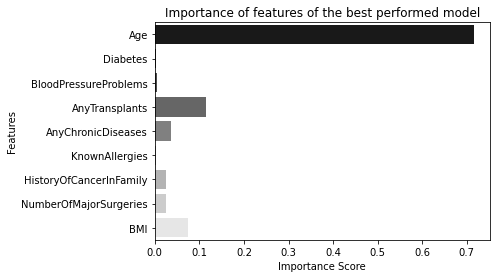

In [233]:
feature_imp = reg_rf.feature_importances_
sns.barplot(x = feature_imp, y = X.columns, palette='gray')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Importance of features of the best performed model')
plt.show()

<h2>Conclusion</h2>

Therefore, the most important features influencing insurance premium are age, transplanted organ and tissue status, Body Mass Index and the existence of the chronic disease. Meanwhile, the driving factor is the customer age. Random Forest model allows us to predict insurance costs based on personal health data with 86% accuracy.  Future work could likely improve predictive performance in the following ways:

- applying k-fold cross-validation;
- using other machine learning algorithms (e.g. XGBoost);
- removing one or more unnecessary features, such as 'KnownAllergies', 'Diabetes' and 'BloodPressureProblems';
- reclassifying the problem as the multinomial classification.


<h2>References</h2>

1. Dubey, N., 2021. Health, term insurance price indices mark a huge jump in Q2: report. Available at: <https://www.livemint.com/insurance/news/health-and-term-insurance-price-index-marks-a-huge-jump-in-q2-report-11625289079669.html> [Accessed 12 October 2021].
2. How useful is the body mass index (BMI)? - Harvard Health. Available at: <https://www.health.harvard.edu/blog/how-useful-is-the-body-mass-index-bmi-201603309339> [Accessed 12 October 2021].
3. Medical Insurance Premium Prediction. Available at: <https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction> [Accessed 12 October 2021].
